# Topic 4: Unsupervised Learning, Autoencoders
### In this notebook, we will use TensorFlow to design an autoencoder for dimensionality reduction using the MNIST dataset

In [51]:
# import some things we need
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Import the MNIST dataset directly from TensorFlow.
The dataset contains 70000 (60000 for training and 10000 for testing) images of handwritten digits from 0 to 9, each with 28x28 pixels (1 channel)

Data source:
@article{lecun2010mnist,
  title={MNIST handwritten digit database},
  author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
  journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
  volume={2},
  year={2010}
}

In [52]:
# This is needed for certain versions of Python
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    uhttpsc = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = uhttpsc

(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

In [53]:
# Shape of training and testing sets
print("Training Images: ", X_train.shape)
print(" Testing Images: ", X_test.shape)
print("Training Labels: ", Y_train.shape)
print(" Testing Labels: ", Y_test.shape)

Training Images:  (60000, 28, 28)
 Testing Images:  (10000, 28, 28)
Training Labels:  (60000,)
 Testing Labels:  (10000,)


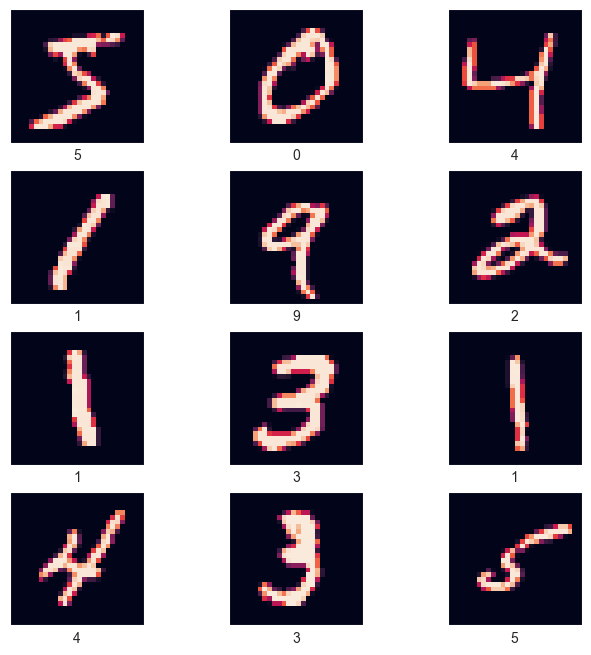

In [54]:
class_labels = [str(i) for i in range(10)]
# show some of the images
fig = plt.figure()
fig.set_size_inches((8, 8))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.imshow(X_train[i])
    plt.xticks(())
    plt.yticks(())
    plt.grid(False)
    plt.xlabel(class_labels[Y_train[i]])

## Building the Autoencoder

We will use the Keras functional API in TensorFlow 2 to create a simple autoencoder out of Dense layers. It would be more appropriate to use a convolutional network for this, however, we will avoid transposed convolutions in this lesson for simplicity purposes.

In [55]:
# this is the dropout rate used on the dropout layers
dropout_rate = 0.8
# this is the size of the latent space
latent_space_size = 20
# Create the input layer, which for these images is 28x28 pixels with a single channel
inputs = keras.Input(shape=(28, 28))
# flatten since we are using dense layers
flattened = keras.layers.Flatten()(inputs)
# add a dense layer
encoder_dense1 = keras.layers.Dense(units=284, activation=keras.activations.sigmoid)(flattened)
# add a dropout layer
encoder_dropout1 = keras.layers.Dropout(rate=dropout_rate)(encoder_dense1)
# add a dense layer
encoder_dense2 = keras.layers.Dense(units=64, activation=keras.activations.sigmoid)(encoder_dropout1)
# add a dropout layer
encoder_dropout2 = keras.layers.Dropout(rate=dropout_rate)(encoder_dense2)
# final dense layer in the encoder, the output from which is the latent space. We typically don't add dropout after the latent space
latent_space = keras.layers.Dense(units=latent_space_size, activation=keras.activations.sigmoid)(encoder_dropout2)
# add a dense layer
decoder_dense1 = keras.layers.Dense(units=64, activation=keras.activations.sigmoid)(latent_space)
# add a dropout layer
decoder_dropout1 = keras.layers.Dropout(rate=dropout_rate)(decoder_dense1)
# add a dense layer
decoder_dense2 = keras.layers.Dense(units=284, activation=keras.activations.sigmoid)(decoder_dropout1)
# add a dropout layer
decoder_dropout2 = keras.layers.Dropout(rate=dropout_rate)(decoder_dense2)
# add a dense layer
decoder_dense3 = keras.layers.Dense(units=784, activation=keras.activations.sigmoid)(decoder_dropout2)
# reshape into the image shape
reconstruction = keras.layers.Reshape((28, 28))(decoder_dense3)

# define the model
model = keras.Model(inputs=inputs, outputs=reconstruction, name="MNIST_autoencoder")

In [56]:
# Show a summary of the model
model.summary()

Model: "MNIST_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 284)               222940    
                                                                 
 dropout_8 (Dropout)         (None, 284)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                18240     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 20)          

In [57]:
# Let's normalize the images
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Compile the model so that it is ready for training
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Nadam()
)

# Notice that the input and target are both the same (X_train)
history = model.fit(X_train, X_train, batch_size=128, epochs=60, validation_split=0.2, callbacks=keras.callbacks.ReduceLROnPlateau())

Epoch 1/60


2022-10-23 23:58:15.342796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


372/375 [============================>.] - ETA: 0s - loss: 0.0743

2022-10-23 23:58:21.052244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 6s 15ms/step - loss: 0.0742 - val_loss: 0.0642 - lr: 0.0010
Epoch 2/60
375/375 [==============================] - 5s 14ms/step - loss: 0.0624 - val_loss: 0.0607 - lr: 0.0010
Epoch 3/60
375/375 [==============================] - 5s 14ms/step - loss: 0.0609 - val_loss: 0.0605 - lr: 0.0010
Epoch 4/60
375/375 [==============================] - 5s 15ms/step - loss: 0.0603 - val_loss: 0.0596 - lr: 0.0010
Epoch 5/60
375/375 [==============================] - 5s 15ms/step - loss: 0.0596 - val_loss: 0.0589 - lr: 0.0010
Epoch 6/60
375/375 [==============================] - 5s 14ms/step - loss: 0.0591 - val_loss: 0.0583 - lr: 0.0010
Epoch 7/60
375/375 [==============================] - 5s 14ms/step - loss: 0.0581 - val_loss: 0.0562 - lr: 0.0010
Epoch 8/60
375/375 [==============================] - 5s 15ms/step - loss: 0.0558 - val_loss: 0.0542 - lr: 0.0010
Epoch 9/60
375/375 [==============================] - 5s 14ms/step - loss: 0.0545 - val_loss: 0.053

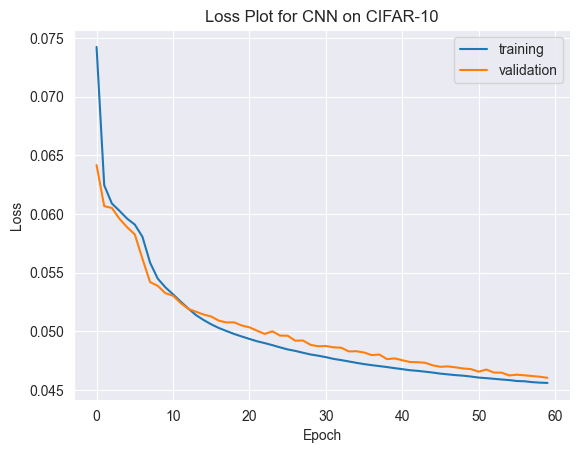

In [58]:
val_loss = history.history["val_loss"]
train_loss = history.history["loss"]

plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Plot for CNN on CIFAR-10")
plt.legend()

 70/313 [=====>........................] - ETA: 0s

2022-10-24 00:03:37.527215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)


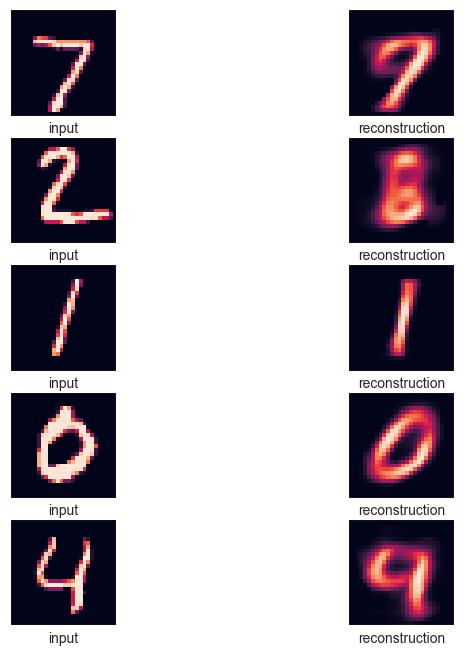

In [59]:
reconstructed_test = model.predict(X_test)
# Let's look at some examples
fig, ax = plt.subplots(nrows=5, ncols=2)
fig.set_size_inches((8, 8))
for i in range(5):
    input_image = X_test[i]
    print(input_image.shape)
    reconstructed = reconstructed_test[i]
    ax[i, 0].imshow(input_image)
    ax[i, 1].imshow(reconstructed)
    ax[i, 0].set_xlabel("input")
    ax[i, 1].set_xlabel("reconstruction")
    ax[i, 0].set_xticks(())
    ax[i, 1].set_xticks(())
    ax[i, 0].set_yticks(())
    ax[i, 1].set_yticks(())
plt.grid(False)

In [60]:
X_test[0].shape

(28, 28)